# CTD 2003 Subset - Online retrieval optimized for applications
## Introduction
This Notebook provides support to application developers, for them to analyse and optimise their online access to NetCDF datasets via queries to an OPeNDAP Server. 

The test dataset used in this Notebook file was prepared by Terradue out of the IMR CTD products exploited for the EC INTAROS project (https://cordis.europa.eu/project/id/727890).

The test dataset has been uploaded on both the OPeNDAP TDS and Hyrax servers, hosted on Terradue Cloud Platform: 
https://opendap.terradue.com/thredds/dodsC/subset_2003/
https://opendap.terradue.com/hyrax/data/subset_2003/

# Exploratory Data Analysis

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pprint
import xarray as xr
import requests
import re

from helpers import *

## Set-up

### Server URL

In [2]:
# Define URLs of servers  
hyrax_url = 'https://opendap.terradue.com/hyrax/data/subset_2003/' # on HYRAX server
thredds_url = 'https://opendap.terradue.com/thredds/dodsC/subset_2003/' # on THREDDS server

# Choose the one you want to use (hyrax_url or thredds_url)
server_url = hyrax_url # or thredds_url

### Define Year and Platform Codes 
The information on **year** and **platforms** available on the server (the individual NetCDF files) must be known a priori 

In [3]:
year = 2003 # Define year of interest
platform_codes = ['AA', 'GS', 'GT', 'HJ', 'JH'] # Define codes of platforms of interest

## Retrieval of DDS info
Access data using the dds info, to retrieve the dimensions of the data for each dimensions: 'TIME', 'LATITUDE', 'LONGITUDE', 'DEPTH', 'POSITION'

In [4]:
# Get dds info, and assign max dimensions to TIME and DEPTH
pc_dim_dict = {}
time_stop_dict = {}
depth_stop_dict = {}

for pc in platform_codes:
    
    dds = f'{server_url}/58{pc}_CTD_{year}.nc.nc4.dds'
    
    pc_dim_dict[pc] = retrieveDDSinfo(dds)
    
    time_stop_dict[pc] = pc_dim_dict[pc]['TIME']
    depth_stop_dict[pc] = pc_dim_dict[pc]['DEPTH']

#pprint.pprint(pc_dim_dict)
print('TIME:', time_stop_dict)
print('DEPTH:', depth_stop_dict)

TIME: {'AA': 683, 'GS': 404, 'GT': 990, 'HJ': 178, 'JH': 949}
DEPTH: {'AA': 2809, 'GS': 3683, 'GT': 2956, 'HJ': 789, 'JH': 3763}


## Visual Analysis: Load and Plot Positions only
The objective of this section is to visualise the geograhical positions of the data for each platform, and to perform some filtering operations based on locations and time queries. This is possible using only the necessary information retrieved from the DDS. The key dimensions that are used for the position analysis are: 'TIME', 'LATITUDE', 'LONGITUDE'. 

### Create Position_Dict

In [5]:
position_dict = {}

for pc in platform_codes:
    
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want
    
    fix_lab = f'58{pc}_CTD_{year}' # label to use for this campaign
    
    url = f'{server_url}{fix_lab}.nc.nc4?{coords_str}'; print(f'Platform: {pc}. URL with Queries:', url)
    
    remote_data, data_attr = fetch_data(url)
    
    position_dict[pc] = {'data': remote_data, 
                         'data_attr': data_attr}
    
#     print(f'{data_attr}\n')
    
# display(position_dict)

# print(pc_dim_dict)

Platform: AA. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58AA_CTD_2003.nc.nc4?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683]
Platform: GS. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58GS_CTD_2003.nc.nc4?TIME[0:1:404],LATITUDE[0:1:404],LONGITUDE[0:1:404]
Platform: GT. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58GT_CTD_2003.nc.nc4?TIME[0:1:990],LATITUDE[0:1:990],LONGITUDE[0:1:990]
Platform: HJ. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58HJ_CTD_2003.nc.nc4?TIME[0:1:178],LATITUDE[0:1:178],LONGITUDE[0:1:178]
Platform: JH. URL with Queries: https://opendap.terradue.com/hyrax/data/subset_2003/58JH_CTD_2003.nc.nc4?TIME[0:1:949],LATITUDE[0:1:949],LONGITUDE[0:1:949]


### Match and merge LAT, LONG and TIME of positions in a *position_df* dataframe
Generate a pandas dataframe (*lonlat_df*) to store all locations (**Longitude** and **Latitude**) and respective **Time** for all platforms. 

In [6]:
# Load locations (long & lat) and TIME of ALL measurements
from datetime import datetime, timedelta
start_date = datetime(1950, 1, 1)
    
position_df = pd.DataFrame() 

for key in position_dict.keys():
    test = pd.DataFrame()
    
    test['Longitude'] = position_dict[key]['data']['LONGITUDE'].data.astype(float)
    test['Latitude'] = position_dict[key]['data']['LATITUDE'].data.astype(float)
    test['Time'] = position_dict[key]['data']['TIME'].data.astype(float)
    test['Platform'] = key
    
    # Convert TIME from float to datetime
    test['Time'] = [start_date + timedelta(t) for t in test.loc[:,'Time']]
    length = len(test[test['Platform']==key])
    print(f'Platform {key}: {length} measurement locations.')
    display(test.tail())
    
    position_df = position_df.append(test) 
    
position_df['Index_ABS'] = np.arange(0,len(position_df))
position_df = position_df.rename_axis("Index_Relative")

print(f'\nMerged dataframe with all platforms. Total of {len(position_df)} measurement locations')
position_df

Platform AA: 684 measurement locations.


,Longitude,Latitude,Time,Platform
679,9.7812,63.622799,2003-12-07 19:14:05,AA
680,11.1663,63.758301,2003-12-08 07:20:41,AA
681,10.3622,63.530300,2003-12-08 17:45:03,AA
682,10.9007,63.587700,2003-12-08 21:12:53,AA
683,11.0433,63.917198,2003-12-09 06:15:53,AA


Platform GS: 405 measurement locations.


,Longitude,Latitude,Time,Platform
400,15.846300,68.271698,2003-12-12 11:53:50,GS
401,16.090700,68.362701,2003-12-12 15:59:43,GS
402,16.091000,68.368500,2003-12-12 16:25:28,GS
403,16.091999,68.376198,2003-12-12 16:56:06,GS
404,16.092300,68.384697,2003-12-12 17:34:18,GS


Platform GT: 991 measurement locations.


,Longitude,Latitude,Time,Platform
986,0.5003,57.240501,2003-10-03 22:24:21,GT
987,0.4992,56.780300,2003-10-04 02:38:20,GT
988,-0.3618,56.744801,2003-10-04 10:01:20,GT
989,-0.5513,57.132500,2003-10-04 20:41:28,GT
990,-0.5153,57.690300,2003-10-05 02:31:28,GT


Platform HJ: 179 measurement locations.


,Longitude,Latitude,Time,Platform
174,12.2738,67.741798,2003-11-13 22:24:18,HJ
175,12.6193,67.946503,2003-11-14 00:25:53,HJ
176,10.4858,68.057503,2003-11-14 06:03:13,HJ
177,11.0522,68.175697,2003-11-14 09:56:47,HJ
178,12.4153,68.231300,2003-11-14 15:25:51,HJ


Platform JH: 950 measurement locations.


,Longitude,Latitude,Time,Platform
945,15.6965,71.253998,2003-12-17 11:01:51,JH
946,12.5057,71.252701,2003-12-17 22:14:57,JH
947,13.0053,71.751503,2003-12-18 03:03:55,JH
948,14.9853,71.743301,2003-12-18 07:15:07,JH
949,17.0693,71.751701,2003-12-18 11:53:00,JH



Merged dataframe with all platforms. Total of 3209 measurement locations


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
0,4.6155,60.755299,2003-01-07 05:25:57,AA,0
1,4.4483,60.748299,2003-01-07 06:05:08,AA,1
2,4.2853,60.751499,2003-01-07 08:34:00,AA,2
3,4.1170,60.747799,2003-01-07 09:18:06,AA,3
4,3.9475,60.752201,2003-01-07 09:59:37,AA,4
...,...,...,...,...,...
945,15.6965,71.253998,2003-12-17 11:01:51,JH,3204
946,12.5057,71.252701,2003-12-17 22:14:57,JH,3205
947,13.0053,71.751503,2003-12-18 03:03:55,JH,3206


In [7]:
# Save dataframe to csv
# position_df.to_csv('all_locations.csv', sep=',', header=True)

### Plot Positions
Plot locations on an interactive plot. 

First, define the dataframe that you would like to plot to the **df_toPlot** variable.

In [8]:
df_toPlot = position_df

Hoover your mouse on a location to see longitude and latitude information. All locations are showed in blue, and only filtered locations are shown in red.

In [9]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook

output_notebook() # necessary to show the plot 

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("Platform", "@Platform"),            
        ]
    )

p = figure(plot_width=500, plot_height=500, tools=[hover],
           title="Mouse over the dots")

# p.square('Longitude', 'Latitude', size=6, color='grey', fill_color='white', source=df_toPlot, legend_label="All locations")
p.circle('Longitude', 'Latitude', size=4, color='red', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='AA'], legend_label="Platform AA locations")
p.circle('Longitude', 'Latitude', size=4, color='blue', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='GS'], legend_label="Platform GS locations")
p.circle('Longitude', 'Latitude', size=4, color='green', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='GT'], legend_label="Platform GT locations")
p.circle('Longitude', 'Latitude', size=4, color='black', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='HJ'], legend_label="Platform HJ locations")
p.circle('Longitude', 'Latitude', size=4, color='orange', fill_color='white', source=df_toPlot[df_toPlot['Platform']=='JH'], legend_label="Platform JH locations")

# Add area
# p.quad(left=bbox[0], right=bbox[1], top=bbox[3], bottom=bbox[2], legend_label="Bounding Box", fill_color='grey', fill_alpha=0.0, line_color="black")

p.legend.location = "bottom_right"
show(p)

Loading BokehJS ...

Based on the plotting above, some decisions could be made on bounding box of interest, platform, etc. 

## Filter Positions (based on *position_df*)
This section shows a few examples of data filtering by using the 'LATITUDE', 'LONGITUDE' and 'TIME' dimensions. The following filters are included:
* filter by bounding box (BBOX)
* filter by BBOX and platform's month of collection 
* filter by BBOX and platform's time (hour) of collection
* filter by customised time range 

### Filter by BBOX

In [10]:
# Now apply the arctic bounding box in the format: minLong - maxLong; minLat - maxLat (eg 30W - 60E; 50N - 80 N) 
bbox_dict = {}

bbox_dict['BBOX=ALL'] = [-20, 70, 40, 90] 
bbox_dict['BBOX=Arctic'] = [-30, 60, 50, 80]  
bbox_dict['BBOX=North Sea'] = [-5, 15, 50, 60]

bbox_key = 'BBOX=North Sea'; assert bbox_key in bbox_dict.keys(), 'Key error, please check.' 
bbox = bbox_dict[bbox_key]

In [11]:
# Now remove the ouliers outside bbox
position_df_bbox = position_df[(position_df.loc[:,'Longitude'] >= bbox[0]) & 
                               (position_df.loc[:,'Longitude'] <= bbox[1]) & 
                               (position_df.loc[:,'Latitude'] >= bbox[2]) & 
                               (position_df.loc[:,'Latitude'] <= bbox[3])]
print('Year:', year)
print('BBOX:', bbox_key)

sel_outof_all = f'{len(position_df_bbox)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')
display(position_df_bbox)
#print(position_df_bbox.index) # You can use the display(data[var].data[:][position_df_bbox.index]) to select the physical variables values of only those points within specific bbox

Year: 2003
BBOX: BBOX=North Sea
Selected positions (out of available positions): 564 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
25,-0.9848,59.284801,2003-01-12 19:55:32,AA,25
26,-0.6563,59.284801,2003-01-12 21:10:15,AA,26
27,-0.3618,59.284801,2003-01-12 22:13:23,AA,27
28,0.0065,59.281700,2003-01-12 23:30:54,AA,28
29,0.3293,59.284698,2003-01-13 00:56:57,AA,29
...,...,...,...,...,...
986,0.5003,57.240501,2003-10-03 22:24:21,GT,2075
987,0.4992,56.780300,2003-10-04 02:38:20,GT,2076
988,-0.3618,56.744801,2003-10-04 10:01:20,GT,2077


### Filter by BBOX and Month

In [12]:
month = '08'
period = f'{year}-{month}'
condition = (position_df_bbox['Time']).astype(str).str.contains(period)
position_df_bbox_mm = position_df_bbox[condition]

sel_outof_all = f'{len(position_df_bbox_mm)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

position_df_bbox_mm

Selected positions (out of available positions): 0 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,


### Filter by BBOX and Hour

In [13]:
hour = '05'
hour_expr = f' {hour}:'
condition = (position_df_bbox['Time']).astype(str).str.contains(hour_expr)
position_df_bbox_hh = position_df_bbox[condition]

sel_outof_all = f'{len(position_df_bbox_hh)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

position_df_bbox_hh

Selected positions (out of available positions): 24 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
55,8.1632,57.915798,2003-01-19 05:22:18,AA,55
70,6.3377,57.000198,2003-01-20 05:29:17,AA,70
80,4.6975,57.000702,2003-01-22 05:56:00,AA,80
99,-0.2325,56.999298,2003-01-24 05:14:13,AA,99
141,2.9035,59.282700,2003-03-07 05:06:37,AA,141
142,2.7532,59.282700,2003-03-07 05:45:36,AA,142
159,-2.0922,58.949699,2003-03-08 05:23:26,AA,159
170,3.3368,58.001202,2003-03-09 05:42:38,AA,170
220,7.2558,55.664200,2003-03-15 05:17:13,AA,220


### Filter by Time Range

In [14]:
# Define start and end date in the format [day,month,year]
time_start = [17,6,2003]
time_start = datetime(time_start[2], time_start[1], time_start[0])

time_end = [29,6,2003]
time_end = datetime(time_end[2], time_end[1], time_end[0])

print(f'Time Filter: {time_start.strftime("%Y-%m-%d")} - {time_end.strftime("%Y-%m-%d")}')

position_df_timerange = position_df.loc[(position_df['Time']>=time_start) & 
                                        (position_df['Time']<=time_end)]
display(position_df_timerange)

Time Filter: 2003-06-17 - 2003-06-29


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
566,31.204000,70.748299,2003-06-17 00:41:26,GT,1655
567,31.213301,71.000198,2003-06-17 03:12:43,GT,1656
568,31.216801,71.248497,2003-06-17 06:58:21,GT,1657
569,31.208300,71.500999,2003-06-17 08:55:13,GT,1658
570,31.210501,71.748299,2003-06-17 11:41:23,GT,1659
...,...,...,...,...,...
507,-1.993000,69.002296,2003-06-27 06:11:18,JH,2766
508,-0.641500,68.250999,2003-06-27 15:28:11,JH,2767
509,0.733800,68.250999,2003-06-28 00:09:21,JH,2768


### Create dictionary with list of filtered indices 
This enebles saving the indices of the filtered data into a dictionary, for each platform, which can then be saved, exported to csv file, and loaded to another notebook for further use.

In [15]:
# Create dictionary with list of filtered indices, for each platform 
import pickle
timerange_index = {}

for key in position_df_timerange['Platform'].unique():
    sel = position_df_timerange.loc[position_df_timerange['Platform']==key]
    timerange_index[key] = sel.index.tolist()

# Print index
# pprint.pprint(timerange_index)

# Save dictionary to file
# myfile = open("timerange_index.pkl", "wb")
# pickle.dump(timerange_index, myfile)
# myfile.close()

# # Load dictionary from file
# myfile = open("timerange_index.pkl", "rb")
# timerange_index = pickle.load(myfile)
# myfile.close()
# print(timerange_index)

**OUTPUT**: a list of the indices that have been filtered, which can be exported to csv or saved to a dictionary for further use. 

# Data Processing: Load and Plot selected Data (Variables within DEPTH range)

This section enables accessing data of **only selected variables** and **within a specified DEPTH range**, to avoid fetching unnecessary data and minimise data volume.

The list of variables need to be specified in the *vars_sel* variable. The four variables that are available in this dataset are: 
* **PRES**: Sea Water Pressure
* **TEMP**: Sea Water Temperature
* **PSAL**: Sea Water Practical Salinity
* **CNDC**: Sea Water Electrical Conductivity 

The depth range must also be defined. For some limitations to the DAP syntax, at least one range boundary needs to correspond to one of the two extremes. For example, in a data array of 100 elements starting from 0 to 99, the following scenarios are possible:
* select the first 20 elements, corresponding to the values range 0 - 19 --> ```[first:1:intermediate] (eg [0:1:19])``` work
* select the last 20 elements, corresponsing to the values range 80 - 99 --> ```[intermediate:1:last] (eg [80:1:99])``` work
* select the intermediate 60-80 elements, corresponsing to the values range 60 - 79 --> ```[intermediate_1:1:intermediate_2] (eg [80:1:89])``` does NOT work

## Range 0-20 Test

### Define Selected Variables (*vars_sel*)

In [16]:
# Available variables
vars_main = ['PRES', 'TEMP', 'PSAL', 'CNDC'] 

# Define the selection of variables to use for the analysis (PS use brakets also with only one var, eg ['TEMP'])
vars_sel = ['TEMP', 'PRES']# , 'PSAL', 'CNDC'] 
assert all([elem in vars_main for elem in vars_sel])

### Create **data_dict** dictionary 
Once variables are defined, the DEPTH range must be defined. 

**INSERT BELOW** the desired DEPTH range (in meters) in the two fields of hte following cell, noting that: 
* ***metadata[pc]['depth_m_v1']***: either this is equal to the lower bound (ie index=0)
* ***metadata[pc]['depth_m_v2']***: or is equal to the upper bound (ie index=-1)

Once the variables and DEPTH range are defined, data and their attributes are read iteratively for each platform, and saved into a dictionary *data_dict* which contains:
* the actual data, loaded into an **xarray** for data handling, analysis and visualisation
* the campaign's main attributes: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max)  

In [17]:
data_dict = {}
metadata = {}

for pc in platform_codes:
    
    metadata[pc] = {}
    
    v_min = int(float(position_dict[pc]['data_attr'][6]))
    metadata[pc]['vmin'] = v_min
    metadata[pc]['depth_abs_v1'] = 0 # this is fixed
    metadata[pc]['depth_abs_v2'] = pc_dim_dict[pc]['DEPTH'] # this is fixed
    
    # ==============================================================================
    """
    Define here the DEPTH range of your selection, in meters. Note that either:
    - 'depth_m_v1' is equal to the lower bound (ie index=0), or 
    - 'depth_m_v2' is equal to the upper bound (ie index=-1)
    """
    metadata[pc]['depth_m_v1'] = 0
    metadata[pc]['depth_m_v2'] = 20 #pc_dim_dict[pc]['DEPTH'] 
    # ==============================================================================
    
    assert metadata[pc]['depth_m_v1'] < metadata[pc]['depth_m_v2'], 'ERROR: the lower bound must be lower than the higher bound' 
    assert metadata[pc]['depth_m_v1'] == 0 or metadata[pc]['depth_m_v2'] == pc_dim_dict[pc]['DEPTH'], 'ERROR: one of the two values must be equal to one of the lower/upper bounds'
    
#     print(f'DEPTH range of interest (meters): {metadata[pc]["depth_m_v1"]} - {metadata[pc]["depth_m_v2"]}')
    
    # the start and stop values are adjusted based on the vmin value
    if metadata[pc]['vmin'] == 1: 
        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] # the same
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] # the same, so I have the right size. When I shift and add the nan, I get rid of further element on the right
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']# - 1
            
        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] - 1 # start one element before
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] - 1 # last element is excluded, ie stop one element before. But then I'll have to remoove one element
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1'] - 1 
        
    else:
        metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1']
        metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2']
        
        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']

        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1']
            
    metadata[pc]['depth_newindex4xr_v1'] = 0
    
    pprint.pprint(metadata[pc])
    print(f'{pc} DEPTH range of interest (adjusted with vmin): {metadata[pc]["depth_newindex_v1"]} - {metadata[pc]["depth_newindex_v2"]}')
    
    fix_lab = f'58{pc}_CTD_{year}' # platform_codes and year are defined at the beginning of the notebook 
    
    # Get coordinates (needed for keeping hte correct structure, and for plotting) 
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want
    
    # Extract TIME and DEPTH dimension for queries 
    time_dims = getQuery(pc, start=0, stop=pc_dim_dict[pc]['TIME'])
    depth_dims = getQuery(pc, start=metadata[pc]['depth_newindex_v1'], stop=metadata[pc]['depth_newindex_v2'])#; print(depth_dims)
    
    # join TIME and DEPTH for Variables
    var_str_ALL = []
    for var in vars_sel: var_str_ALL = np.append(var_str_ALL, f'{var}{time_dims}{depth_dims}')
    queries_vars = ','.join(var_str_ALL)
 
    # Build url and url with queries (url_q)
    url = f'{server_url}{fix_lab}.nc.nc4?{coords_str}' 
    url_q = f'{url},{queries_vars}'; print(f'Platform {pc} URL:', url_q)
        
    remote_data, data_attr = fetch_data(url_q)
    
    data_dict[pc] = {'data': remote_data, 
                     'data_attr': data_attr}
    
    print(f'{data_attr}\n')

# display(data_dict)
print(f'Checking the existing campaigns in the dictionary: {list(data_dict.keys())}')

{'depth_abs_v1': 0,
 'depth_abs_v2': 2809,
 'depth_m_v1': 0,
 'depth_m_v2': 20,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 20,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 20,
 'vmin': 0}
AA DEPTH range of interest (adjusted with vmin): 0 - 20
Platform AA URL: https://opendap.terradue.com/hyrax/data/subset_2003/58AA_CTD_2003.nc.nc4?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683],TEMP[0:1:683][0:1:20],PRES[0:1:683][0:1:20]
['58AA' 'H\\\\303\\\\245kon Mosby' '2003' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '0.000'
 '2811.000' '-11.884' '17.833' '53.996' '69.999']

{'depth_abs_v1': 0,
 'depth_abs_v2': 3683,
 'depth_m_v1': 0,
 'depth_m_v2': 20,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 20,
 'depth_newindex_v1': 0,
 'depth_newindex_v2': 20,
 'vmin': 1}
GS DEPTH range of interest (adjusted with vmin): 0 - 20
Platform GS URL: https://opendap.terradue.com/hyrax/data/subset_2003/58GS_CTD_2003.nc.nc4?TIME[0:1:404],LATIT

In [18]:
# Show xarray.Dataset of one platform as example
# data_dict['AA']['data']

### Create Overview Dataframe with Platforms' Attributes
An overview dataframe *overview_df* is then generated to show the detailed information about each campaign at sea: *platform code & name*, *data type*, *title*, *instrument*, *longitude* & *latitude*, and *vertical min & max*).

In [19]:
# Create database with the selected campaigns & years
overview_df = pd.DataFrame()
overview_df = getAttributes(overview_df, data_dict)
overview_df

,Platform_code,Platform_name,Year,Data_type,Title,Instrument,Vertical_min,Vertical_max,Lon_min,Lon_max,Lat_min,Lat_max
AA,58AA,H\\303\\245kon Mosby,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,0.0,2811.0,-11.884,17.833,53.996,69.999
GS,58GS,G.O. Sars,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3688.0,-17.979,22.532,59.280,78.336
GT,58GT,Sarsen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,2962.0,-9.520,35.016,56.667,78.655
HJ,58HJ,Helmer Hanssen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,792.0,6.303,39.826,63.889,81.179
JH,58JH,Johan Hjort,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3766.0,-15.502,47.017,50.998,77.829


In [20]:
# Extract / define the variables to use for the analysis
for key in data_dict.keys():
    print(key, list(data_dict[key]['data'].variables))

AA ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
GS ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
GT ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
HJ ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
JH ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']


### Define Filtered Data (*df_toPlot*)
Define the filtered dataframe to use for the analysis (eg *position_df_bbox*, *position_df_bbox_mm*, *position_df_bbox_hh*) to the **df_toPlot** variable.

In [21]:
# Define dataframe to plot based on one of the previously defined filters
df_toPlot = position_df_bbox
print('BBOX:', bbox_key)

sel_outof_all = f'{len(df_toPlot)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

display(df_toPlot)

BBOX: BBOX=North Sea
Selected positions (out of available positions): 564 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
25,-0.9848,59.284801,2003-01-12 19:55:32,AA,25
26,-0.6563,59.284801,2003-01-12 21:10:15,AA,26
27,-0.3618,59.284801,2003-01-12 22:13:23,AA,27
28,0.0065,59.281700,2003-01-12 23:30:54,AA,28
29,0.3293,59.284698,2003-01-13 00:56:57,AA,29
...,...,...,...,...,...
986,0.5003,57.240501,2003-10-03 22:24:21,GT,2075
987,0.4992,56.780300,2003-10-04 02:38:20,GT,2076
988,-0.3618,56.744801,2003-10-04 10:01:20,GT,2077


In [22]:
print('Printing DEPTH range for analyis:')
assert len(np.unique([metadata[k]["depth_m_v1"] for k in metadata.keys()])==1)
assert len(np.unique([metadata[k]["depth_m_v2"] for k in metadata.keys()])==1)

for k in metadata.keys():
    print(f' - Pl. {k}; DEPTH range of interest: {metadata[k]["depth_m_v1"]} - {metadata[k]["depth_m_v2"]}')

Printing DEPTH range for analyis:
 - Pl. AA; DEPTH range of interest: 0 - 20
 - Pl. GS; DEPTH range of interest: 0 - 20
 - Pl. GT; DEPTH range of interest: 0 - 20
 - Pl. HJ; DEPTH range of interest: 0 - 20
 - Pl. JH; DEPTH range of interest: 0 - 20


In [23]:
# Generate vmin dictionary (needed to avoid doing the vmin adjustment more than once)
vmin_dict = {}

# select only those platforms where vmin == 1
vmin_pc = overview_df[overview_df['Vertical_min'] == 1.0].index

for i in vmin_pc:
    vmin_dict[i] = {}
    
    for v in vars_sel:
        vmin_dict[i][v] = False

vmin_dict   

{'GS': {'TEMP': False, 'PRES': False},
 'GT': {'TEMP': False, 'PRES': False},
 'HJ': {'TEMP': False, 'PRES': False},
 'JH': {'TEMP': False, 'PRES': False}}

### Define Platform Code

In [24]:
pc = 'GT'; assert pc in df_toPlot.Platform.unique(); # platform code

### Data Filtering
This section allows filtering one or more variables for each platform within a given DEPTH range, to the data that was previously filtered in the Filtered Position section (eg by "BBOX", by "BBOX and Month", or by "BBOX and Hour"). 

The following are the two types of filters that are given as examples: 
* Filtered data by BBOX and One Variable
* Filtered data by BBOX (All Variables)

The output of both filters is a *filtered_xarr* xarray dataset, containing one or all the variables within the specified DEPTH range. 

#### Data filtered by BBOX and One Variable

In [25]:
# Define var to plot
var = 'TEMP'; assert var in vars_sel # variable

In [26]:
# Generate a filtered xarray with one single VAR for selected Platform, for a certain DEPTH range

if metadata[pc]['depth_m_v1']==0: align_and_nan = True
else: align_and_nan = False
check_alignment(data_dict, pc, var, align_and_nan, vmin_dict)
    
filtered_xarr = filter_xarr(df_toPlot, 
                            data_dict,
                            platform=pc,
                            var=var,
                            depth_range=[metadata[pc]['depth_newindex4xr_v1'],
                                         metadata[pc]['depth_newindex4xr_v2']])
filtered_xarr

Platform: GT - Vertical min = 1.0 --> aligning and add nan
this is a test


<xarray.DataArray 'TEMP' (TIME: 158, DEPTH: 21)>
array([[   nan, 17.678, 17.586, ..., 15.494, 15.467, 15.423],
       [   nan, 16.354, 16.338, ..., 15.974, 15.583, 15.207],
       [   nan, 16.146, 16.094, ..., 15.258, 15.067, 14.912],
       ...,
       [   nan, 12.951, 12.947, ..., 12.967, 12.965, 12.963],
       [   nan, 12.985, 12.983, ..., 12.987, 12.988, 12.988],
       [   nan, 12.891, 12.882, ..., 12.902, 12.902, 12.902]])
Coordinates:
  * TIME     (TIME) float64 1.954e+04 1.954e+04 ... 1.963e+04 1.964e+04
Dimensions without coordinates: DEPTH
Attributes:
    standard_name:        sea_water_temperature
    long_name:            Sea temperature
    units:                degrees_C
    valid_min:            -2500
    valid_max:            40000
    ancillary_variables:  TEMP_QC TEMP_DM
    data_mode:            D

#### Data filtered by BBOX and All Variables

In [27]:
# Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range
for var in vars_sel: 
    
    if metadata[pc]['depth_m_v1']==0: align_and_nan = True
    else: align_and_nan = False
    check_alignment(data_dict, pc, var, align_and_nan, vmin_dict)

filtered_xarr = filter_xarr(df_toPlot, 
                            data_dict, 
                            platform=pc, 
                            var=vars_sel, 
                            depth_range=[metadata[pc]['depth_newindex4xr_v1'],
                                         metadata[pc]['depth_newindex4xr_v2']])

filtered_xarr

Platform: GT - Vertical min = 1.0 --> aligning and add nan
this is a test


<xarray.Dataset>
Dimensions:  (DEPTH: 21, TIME: 158)
Coordinates:
  * TIME     (TIME) float64 1.954e+04 1.954e+04 ... 1.963e+04 1.964e+04
Dimensions without coordinates: DEPTH
Data variables:
    TEMP     (TIME, DEPTH) float64 nan 17.68 17.59 17.54 ... 12.9 12.9 12.9 12.9
    PRES     (TIME, DEPTH) float32 nan 2.0 3.0 4.0 5.0 ... 19.0 20.0 21.0 22.0
Attributes: (12/117)
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    citation:                       These data were collected and made freely...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

### Reference Plots
The reference plots are generated for the available **variables** of the **filtered** xarrays. On the y-axis is shown the TIME of the measurement (in *float* format, which needs to be converted to *datetime* format), and on the x-axis is the DEPTH of the measurement.

#### Plotting individual Variables per individual Platform

There are multiple VARs available from the applied filtered: ['TEMP', 'PRES']


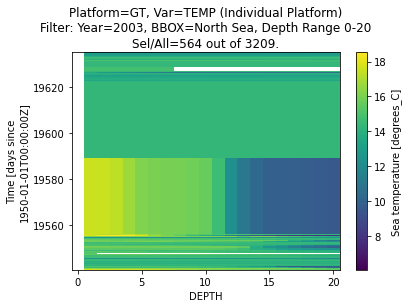

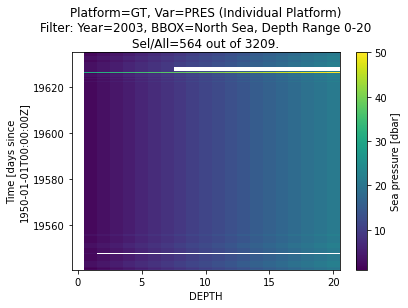

In [28]:
myvars = list(filtered_xarr.keys()) #filtered_xarr.name

if len(myvars) == 1:
    var = myvars[0]
    print(f"There's only one VAR available from the applied filtered: {var}")

    title = f'Platform={pc}, Var={var} (Individual Platform)\nFilter: Year={year}, {bbox_key}, Depth Range {metadata[pc]["depth_m_v1"]}-{metadata[pc]["depth_m_v2"]}\nSel/All={sel_outof_all}'

    plotFilteredVar(filtered_xarr[var], title=title)

else:
    print(f"There are multiple VARs available from the applied filtered: {myvars}")
    
    for var in myvars:
        
        title = f'Platform={pc}, Var={var} (Individual Platform)\nFilter: Year={year}, {bbox_key}, Depth Range {metadata[pc]["depth_m_v1"]}-{metadata[pc]["depth_m_v2"]}\nSel/All={sel_outof_all}'

        plotFilteredVar(filtered_xarr[var], title=title)

#### Plotting individual Variables across aggregated Platforms
Build a dictionary that stores, for each platform and variable combination, the data sliced using the same DEPTH dimension in such a way to generate datasets that can be combined / merged.

##### Generate **filtered_xarr_dict** for all Platforms

In [29]:
# Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range
filtered_xarr_dict = {}

for pc in df_toPlot['Platform'].unique():
    
    for var in vars_sel: 
        
        if metadata[pc]['depth_m_v1']==0: align_and_nan = True
        else: align_and_nan = False
        check_alignment(data_dict, pc, var, align_and_nan, vmin_dict)
                
    filtered_xarr_dict[pc] = filter_xarr(df_toPlot, 
                                         data_dict, 
                                         platform=pc, 
                                         var=vars_sel, 
                                         depth_range=[metadata[pc]["depth_newindex4xr_v1"],
                                                      metadata[pc]["depth_newindex4xr_v2"]])
    
# filtered_xarr_dict

Platform: AA - Vertical min = 0.0
Platform: AA - Vertical min = 0.0
Platform: GS - Vertical min = 1.0 --> aligning and add nan
this is a test
Platform: GS - Vertical min = 1.0 --> aligning and add nan
this is a test


In [30]:
data_var_dict = {}

for pc in df_toPlot['Platform'].unique(): 
    
    data_var_dict[pc] = {}
    data = filtered_xarr_dict[pc]
    
    print(f'PC {pc}\tFiltered Dims: TIME={data.dims["TIME"]}, DEPTH={data.dims["DEPTH"]}')

    for var in vars_sel:
        data_var_dict[pc][var] = filtered_xarr_dict[pc][var]

# display(data_var_dict)

PC AA	Filtered Dims: TIME=357, DEPTH=21
PC GS	Filtered Dims: TIME=49, DEPTH=21
PC GT	Filtered Dims: TIME=158, DEPTH=21


##### Aggregation
Two xarray datasets can be merged if they have the same structure, i.e. dimensions. Here we use two aggregation methods that allow doing that, in two different ways: using the **min_depth_elements** and **max_depth_elements**, which are defined as follows: 
* **min_depth_elements** = least common denominator for the DEPTH dimension found amongst the elements of the selected platforms
* **max_depth_elements** = maximum value of the DEPTH dimension found amongst the elements of the selected platforms 

The two aggregation methods are:
* Aggregation with **min_depth_elements**: data are aggregated using the minimum dimension of depth. The xarrays of those platforms that have a larger depth dimension will be truncated to the common minimum dimension.       
* Aggregation with **max_depth_elements**: data are aggregated using the maximum dimension of depth. The xarrays of those platforms that have a lower depth dimension will have their dimension increased to the common maximum dimension and filled with nans.

In [31]:
print(f'P.Code (TIME, DEPTH)')
[print(k, data_var_dict[k]["TEMP"].shape) for k in data_var_dict.keys()]

# Find maximum and minimum DEPTH dimension among the platforms
max_depth_elements = max([data_var_dict[k]['TEMP'].shape[1] for k in data_var_dict.keys()]); print('max_depth_elements:', max_depth_elements)
min_depth_elements = min([data_var_dict[k]['TEMP'].shape[1] for k in data_var_dict.keys()]); print('min_depth_elements:', min_depth_elements)

P.Code (TIME, DEPTH)
AA (357, 21)
GS (49, 21)
GT (158, 21)
max_depth_elements: 21
min_depth_elements: 21


**NB**: if *min_depth_elements* and *max_depth_elements* are equal to each other, either aggregation methods (with min_depth_elements or with max_depht_elements) will lead to the same result. 

###### Aggregate with **min_depth_elements**
Use minimum DEPTH across the platforms' DEPTHs

In [32]:
# Use min_depth_elements across available platforms: Reduce size to the minimum dimension 
print(f'Reshaping using minimum DEPTH dimension ({min_depth_elements}):')

reshaped_dict = {}

for pc in data_var_dict.keys():
    reshaped_dict[pc] = {}
    
    for var in vars_sel:
        
        data = data_var_dict[pc][var].isel(DEPTH=slice(0,min_depth_elements)); #display(data_sel)
        
        print(f'{data_var_dict[pc][var].shape} --> {data.shape}')
        
        reshaped_dict[pc][var] = data
        
# reshaped_dict

Reshaping using minimum DEPTH dimension (21):
(357, 21) --> (357, 21)
(357, 21) --> (357, 21)
(49, 21) --> (49, 21)
(49, 21) --> (49, 21)
(158, 21) --> (158, 21)
(158, 21) --> (158, 21)


###### Aggregate with **max_depth_elements**
use maximum DEPTH across all platforms' DEPTHs, and fill empty values with nans

In [33]:
print(f'Reshaping using maximum DEPTH dimension ({max_depth_elements}):')

reshaped_dict = {}

for pc in data_var_dict.keys():
    reshaped_dict[pc] = {}
    
    for var in vars_sel:
        
        arr = data_var_dict[pc][var]
        
        # generate an empty array of nans, to then concatenate to the existing data array, to ensure it matches the desired new dimension DEPTH 
        fill = np.empty((arr.shape[0], max_depth_elements-arr.shape[1]), dtype=arr.dtype); fill[:] = np.nan
        newarr_data = np.concatenate((arr.data,fill), axis=1)
        print(f'{arr.shape} --> {newarr_data.shape}')
        
        # Now create the xarray.DataArray
        newarr = newXDA(arr, newarr_data, var)
        
        reshaped_dict[pc][var] = newarr

# reshaped_dict

Reshaping using maximum DEPTH dimension (21):
(357, 21) --> (357, 21)
(357, 21) --> (357, 21)
(49, 21) --> (49, 21)
(49, 21) --> (49, 21)
(158, 21) --> (158, 21)
(158, 21) --> (158, 21)


##### Plotting Aggregate Results

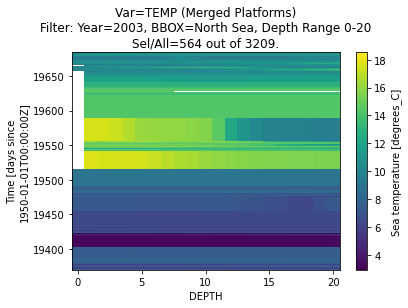

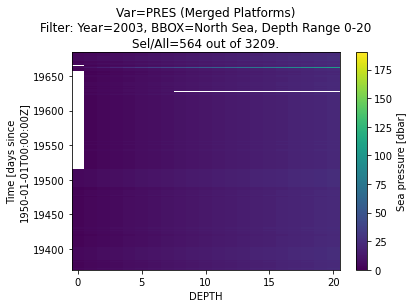

In [34]:
# Combine arrays across platforms, for each variable
merged_arr = {}

for var in vars_sel:
        
    merged_arr[var] = xr.merge([reshaped_dict[pc][var] for pc in reshaped_dict.keys()])  
    
#     print(var, type(merged_arr[var]), merged_arr[var][var].shape) # Note you need double 'var' because the first is the key of teh dictionary, the second is the name of the var to plot
#     display(merged_arr[var])
    
    title = f'Var={var} (Merged Platforms)\nFilter: Year={year}, {bbox_key}, Depth Range {metadata[pc]["depth_m_v1"]}-{metadata[pc]["depth_m_v2"]}\nSel/All={sel_outof_all}'

    plotVar_MergedPlatforms(merged_arr[var], var, title=title)

## Range 50-last Test

### Define Selected Variables (*vars_sel*)

In [35]:
# Available variables
vars_main = ['PRES', 'TEMP', 'PSAL', 'CNDC'] 

# Define the selection of variables to use for the analysis (PS use brakets also with only one var, eg ['TEMP'])
vars_sel = ['TEMP', 'PRES'] # 'PSAL', 'CNDC'] # 
assert all([elem in vars_main for elem in vars_sel])

### Create **data_dict** dictionary 
Once variables and depth range are defined, the data and their attributes are read iteratively for each platform, and saved into a dictionary *data_dict* which contains:
* the actual data, loaded into an **xarray** for data handling, analysis and visualisation
* the campaign's main attributes: platform code & name, data type, title, instrument, longitude & latitude, and vertical min & max)  


**Define DEPTH range (INSERT BELOW)** the desired DEPTH range (in meters) in the two fields below, noting that: 
* ***metadata[pc]['depth_m_v1']***: either this is equal to the lower bound (ie index=0)
* ***metadata[pc]['depth_m_v2']***: or is equal to the upper bound (ie index=-1)

In [36]:
data_dict = {}
metadata = {}

for pc in platform_codes:
    
    metadata[pc] = {}
    
    v_min = int(float(position_dict[pc]['data_attr'][6]))
    metadata[pc]['vmin'] = v_min
    metadata[pc]['depth_abs_v1'] = 0 # this is fixed
    metadata[pc]['depth_abs_v2'] = pc_dim_dict[pc]['DEPTH'] # this is fixed
    
    # ==============================================================================
    """
    Define here the DEPTH range of your selection, in meters. Note that either:
    - 'depth_m_v1' is equal to the lower bound (ie index=0), or 
    - 'depth_m_v2' is equal to the upper bound (ie index=-1)
    """
    metadata[pc]['depth_m_v1'] = 50
    metadata[pc]['depth_m_v2'] = pc_dim_dict[pc]['DEPTH'] 
    # ==============================================================================
    
    assert metadata[pc]['depth_m_v1'] < metadata[pc]['depth_m_v2'], 'ERROR: the lower bound must be lower than the higher bound' 
    assert metadata[pc]['depth_m_v1'] == 0 or metadata[pc]['depth_m_v2'] == pc_dim_dict[pc]['DEPTH'], 'ERROR: one of the two values must be equal to one of the lower/upper bounds'
    
#     print(f'DEPTH range of interest (meters): {metadata[pc]["depth_m_v1"]} - {metadata[pc]["depth_m_v2"]}')
    
    # the start and stop values are adjusted based on the vmin value
    if metadata[pc]['vmin'] == 1: 
        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] # the same
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] # the same, so I have the right size. When I shift and add the nan, I get rid of further element on the right
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - 1
            
        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1'] - 1 # start one element before
            metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2'] - 1 # last element is excluded, ie stop one element before. But then I'll have to remoove one element
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1'] - 1 
        
    else:
        metadata[pc]['depth_newindex_v1'] = metadata[pc]['depth_m_v1']
        metadata[pc]['depth_newindex_v2'] = metadata[pc]['depth_m_v2']
        
        if metadata[pc]['depth_m_v1'] == 0: # 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2']

        elif metadata[pc]['depth_m_v1'] != 0: 
            metadata[pc]['depth_newindex4xr_v2'] = metadata[pc]['depth_m_v2'] - metadata[pc]['depth_m_v1']
            
    metadata[pc]['depth_newindex4xr_v1'] = 0
    
    pprint.pprint(metadata[pc])
    print(f'{pc} DEPTH range of interest (adjusted with vmin): {metadata[pc]["depth_newindex_v1"]} - {metadata[pc]["depth_newindex_v2"]}')
    
    fix_lab = f'58{pc}_CTD_{year}' # platform_codes and year are defined at the beginning of the notebook 
    
    # Get coordinates (needed for keeping hte correct structure, and for plotting) 
    coords_str = getQueryString(pc_dim_dict[pc], keylist = ['TIME', 'LATITUDE', 'LONGITUDE']) # list the coordinates you want
    
    # Extract TIME and DEPTH dimension for queries 
    time_dims = getQuery(pc, start=0, stop=pc_dim_dict[pc]['TIME'])
    depth_dims = getQuery(pc, start=metadata[pc]['depth_newindex_v1'], stop=metadata[pc]['depth_newindex_v2'])#; print(depth_dims)
    
    # join TIME and DEPTH for Variables
    var_str_ALL = []
    for var in vars_sel: var_str_ALL = np.append(var_str_ALL, f'{var}{time_dims}{depth_dims}')
    queries_vars = ','.join(var_str_ALL)
 
    # Build url and url with queries (url_q)
    url = f'{server_url}{fix_lab}.nc.nc4?{coords_str}' 
    url_q = f'{url},{queries_vars}'; print(f'Platform {pc} URL:', url_q)
        
    remote_data, data_attr = fetch_data(url_q)
    
    data_dict[pc] = {'data': remote_data, 
                     'data_attr': data_attr}
    
    print(f'{data_attr}\n')

# display(data_dict)
print(f'Checking the existing campaigns in the dictionary: {list(data_dict.keys())}')

{'depth_abs_v1': 0,
 'depth_abs_v2': 2809,
 'depth_m_v1': 50,
 'depth_m_v2': 2809,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 2759,
 'depth_newindex_v1': 50,
 'depth_newindex_v2': 2809,
 'vmin': 0}
AA DEPTH range of interest (adjusted with vmin): 50 - 2809
Platform AA URL: https://opendap.terradue.com/hyrax/data/subset_2003/58AA_CTD_2003.nc.nc4?TIME[0:1:683],LATITUDE[0:1:683],LONGITUDE[0:1:683],TEMP[0:1:683][50:1:2809],PRES[0:1:683][50:1:2809]
['58AA' 'H\\\\303\\\\245kon Mosby' '2003' 'OceanSITES vertical profile'
 'Arctic Ocean - In Situ Observation Copernicus' 'CTD Seabird' '0.000'
 '2811.000' '-11.884' '17.833' '53.996' '69.999']

{'depth_abs_v1': 0,
 'depth_abs_v2': 3683,
 'depth_m_v1': 50,
 'depth_m_v2': 3683,
 'depth_newindex4xr_v1': 0,
 'depth_newindex4xr_v2': 3632,
 'depth_newindex_v1': 49,
 'depth_newindex_v2': 3682,
 'vmin': 1}
GS DEPTH range of interest (adjusted with vmin): 49 - 3682
Platform GS URL: https://opendap.terradue.com/hyrax/data/subset_2003/58GS_CTD_200

In [37]:
# Show xarray.Dataset of one platform as example
# data_dict['AA']['data']

### Create Overview Dataframe with Platforms' Attributes
An overview dataframe *overview_df* is then generated to show the detailed information about each campaign at sea: *platform code & name*, *data type*, *title*, *instrument*, *longitude* & *latitude*, and *vertical min & max*).

In [38]:
# Create database with the selected campaigns & years
overview_df = pd.DataFrame()
overview_df = getAttributes(overview_df, data_dict)
overview_df

,Platform_code,Platform_name,Year,Data_type,Title,Instrument,Vertical_min,Vertical_max,Lon_min,Lon_max,Lat_min,Lat_max
AA,58AA,H\\303\\245kon Mosby,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,0.0,2811.0,-11.884,17.833,53.996,69.999
GS,58GS,G.O. Sars,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3688.0,-17.979,22.532,59.280,78.336
GT,58GT,Sarsen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,2962.0,-9.520,35.016,56.667,78.655
HJ,58HJ,Helmer Hanssen,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,792.0,6.303,39.826,63.889,81.179
JH,58JH,Johan Hjort,2003.0,OceanSITES vertical profile,Arctic Ocean - In Situ Observation Copernicus,CTD Seabird,1.0,3766.0,-15.502,47.017,50.998,77.829


In [39]:
# Extract / define the variables to use for the analysis
for key in data_dict.keys():
    print(key, list(data_dict[key]['data'].variables))

AA ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
GS ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
GT ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
HJ ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']
JH ['TIME', 'LATITUDE', 'LONGITUDE', 'PRES', 'TEMP']


### Filtered dataframe (*df_toPlot*)
Define the filtered dataframe to use for the analysis (eg *position_df_bbox*, *position_df_bbox_mm*, *position_df_bbox_hh*) to the **df_toPlot** variable.

In [40]:
# Define dataframe to plot based on one of the previously defined filters
df_toPlot = position_df_bbox
print('BBOX:', bbox_key)

sel_outof_all = f'{len(df_toPlot)} out of {len(position_df)}.'
print(f'Selected positions (out of available positions): {sel_outof_all}')

display(df_toPlot)

BBOX: BBOX=North Sea
Selected positions (out of available positions): 564 out of 3209.


,Longitude,Latitude,Time,Platform,Index_ABS
Index_Relative,,,,,
25,-0.9848,59.284801,2003-01-12 19:55:32,AA,25
26,-0.6563,59.284801,2003-01-12 21:10:15,AA,26
27,-0.3618,59.284801,2003-01-12 22:13:23,AA,27
28,0.0065,59.281700,2003-01-12 23:30:54,AA,28
29,0.3293,59.284698,2003-01-13 00:56:57,AA,29
...,...,...,...,...,...
986,0.5003,57.240501,2003-10-03 22:24:21,GT,2075
987,0.4992,56.780300,2003-10-04 02:38:20,GT,2076
988,-0.3618,56.744801,2003-10-04 10:01:20,GT,2077


In [41]:
# Generate vmin dictionary (needed to avoid doing the vmin adjustment more than once)
vmin_dict = {}

# select only those platforms where vmin == 1
vmin_pc = overview_df[overview_df['Vertical_min'] == 1.0].index

for i in vmin_pc:
    vmin_dict[i] = {}
    
    for v in vars_sel:
        vmin_dict[i][v] = False

vmin_dict   

{'GS': {'TEMP': False, 'PRES': False},
 'GT': {'TEMP': False, 'PRES': False},
 'HJ': {'TEMP': False, 'PRES': False},
 'JH': {'TEMP': False, 'PRES': False}}

### Selected DEPTH range

In [42]:
print('Printing DEPTH range for analyis:')
assert len(np.unique([metadata[k]["depth_m_v1"] for k in metadata.keys()])==1)
assert len(np.unique([metadata[k]["depth_m_v2"] for k in metadata.keys()])==1)

for k in metadata.keys():
    print(f' - Pl. {k}; DEPTH range of interest: {metadata[k]["depth_m_v1"]} - {metadata[k]["depth_m_v2"]}')

Printing DEPTH range for analyis:
 - Pl. AA; DEPTH range of interest: 50 - 2809
 - Pl. GS; DEPTH range of interest: 50 - 3683
 - Pl. GT; DEPTH range of interest: 50 - 2956
 - Pl. HJ; DEPTH range of interest: 50 - 789
 - Pl. JH; DEPTH range of interest: 50 - 3763


### Define Platform Code

In [43]:
pc = 'GT'; assert pc in df_toPlot.Platform.unique(); # platform code

### Data Filtering
This section allows filtering one or more variables for each platform within a given DEPTH range, to the data that was previously filtered in the Filtered Position section (eg by "BBOX", by "BBOX and Month", or by "BBOX and Hour"). 

The following are the two types of filters that are given as examples: 
* Filtered data by BBOX and One Variable
* Filtered data by BBOX (All Variables)

The output of both filters is a *filtered_xarr* xarray dataset, containing one or all the variables within the specified DEPTH range. 

#### Data filtered by BBOX and One Variable

In [44]:
# Define var to plot
var = 'TEMP'; assert var in vars_sel # variable

In [45]:
# Generate a filtered xarray with one single VAR for selected Platform, for a certain DEPTH range

if metadata[pc]['depth_m_v1']==0: align_and_nan = True
else: align_and_nan = False
check_alignment(data_dict, pc, var, align_and_nan, vmin_dict)
    
filtered_xarr = filter_xarr(df_toPlot, 
                            data_dict, 
                            platform=pc, 
                            var=var, 
                            depth_range=[metadata[pc]['depth_newindex4xr_v1'],
                                         metadata[pc]['depth_newindex4xr_v2']])
filtered_xarr

Platform: GT - Vertical min = 1.0 --> data has been aligned already


<xarray.DataArray 'TEMP' (TIME: 158, DEPTH: 2858)>
array([[   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [ 9.165,  9.136,  9.08 , ...,    nan,    nan,    nan],
       [ 9.099,  9.08 ,  9.045, ...,    nan,    nan,    nan],
       ...,
       [11.981, 11.981, 11.981, ...,    nan,    nan,    nan],
       [12.992, 12.992, 12.992, ...,    nan,    nan,    nan],
       [12.904, 12.904, 12.905, ...,    nan,    nan,    nan]])
Coordinates:
  * TIME     (TIME) float64 1.954e+04 1.954e+04 ... 1.963e+04 1.964e+04
Dimensions without coordinates: DEPTH
Attributes:
    standard_name:        sea_water_temperature
    long_name:            Sea temperature
    units:                degrees_C
    valid_min:            -2500
    valid_max:            40000
    ancillary_variables:  TEMP_QC TEMP_DM
    data_mode:            D

#### Data filtered by BBOX and All Variables

In [46]:
# Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range
for var in vars_sel: 
    
    if metadata[pc]['depth_m_v1']==0: align_and_nan = True
    else: align_and_nan = False
    check_alignment(data_dict, pc, var, align_and_nan, vmin_dict)
        
filtered_xarr = filter_xarr(df_toPlot, 
                            data_dict, 
                            platform=pc, 
                            var=vars_sel, 
                            depth_range=[metadata[pc]['depth_newindex4xr_v1'],
                                         metadata[pc]['depth_newindex4xr_v2']])

filtered_xarr

Platform: GT - Vertical min = 1.0 --> data has been aligned already


<xarray.Dataset>
Dimensions:  (DEPTH: 2858, TIME: 158)
Coordinates:
  * TIME     (TIME) float64 1.954e+04 1.954e+04 ... 1.963e+04 1.964e+04
Dimensions without coordinates: DEPTH
Data variables:
    TEMP     (TIME, DEPTH) float64 nan nan nan nan nan ... nan nan nan nan nan
    PRES     (TIME, DEPTH) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/117)
    title:                          Arctic Ocean - In Situ Observation Copern...
    qc_manual:                      Recommendations for in-situ data Near Rea...
    contact:                        cmems-service@imr.no
    format_version:                 1.4
    distribution_statement:         These data follow Copernicus standards; t...
    citation:                       These data were collected and made freely...
    ...                             ...
    CNDC_QC.conventions:            Copernicus Marine In Situ reference table 2
    CNDC_QC.valid_min:              0
    CNDC_QC.valid_max:              9
    CNDC_QC.flag_values:            [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    CNDC_QC.flag_meanings:          no_qc_performed good_data probably_good_d...
    CNDC_QC.long_name:              Electrical conductivity quality flag

### Reference Plots
The reference plots are generated for the available **variables** of the **filtered** xarrays. On the y-axis is shown the TIME of the measurement (in *float* format, which needs to be converted to *datetime* format), and on the x-axis is the DEPTH of the measurement.

#### Plotting individual Variables per individual Platform

There are multiple VARs available from the applied filtered: ['TEMP', 'PRES']


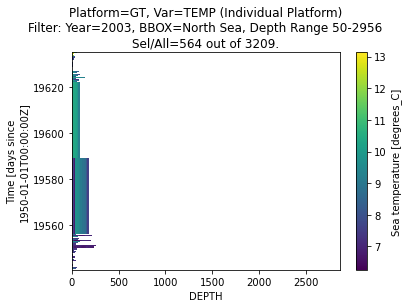

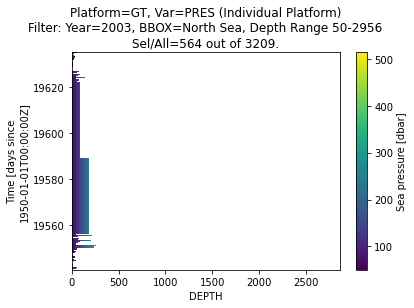

In [47]:
myvars = list(filtered_xarr.keys()) #filtered_xarr.name

if len(myvars) == 1:
    var = myvars[0]
    print(f"There's only one VAR available from the applied filtered: {var}")

    title = f'Platform={pc}, Var={var} (Individual Platform)\nFilter: Year={year}, {bbox_key}, Depth Range {metadata[pc]["depth_m_v1"]}-{metadata[pc]["depth_m_v2"]}\nSel/All={sel_outof_all}'

    plotFilteredVar(filtered_xarr[var], title=title)

else:
    print(f"There are multiple VARs available from the applied filtered: {myvars}")
    
    for var in myvars:
        
        title = f'Platform={pc}, Var={var} (Individual Platform)\nFilter: Year={year}, {bbox_key}, Depth Range {metadata[pc]["depth_m_v1"]}-{metadata[pc]["depth_m_v2"]}\nSel/All={sel_outof_all}'

        plotFilteredVar(filtered_xarr[var], title=title)

#### Plotting individual Variables across aggregated Platforms
Build a dictionary that stores, for each platform and variable combination, the data sliced using the same DEPTH dimension in such a way to generate datasets that can be combined / merged.

##### Generate **filtered_xarr_dict** for all Platforms

In [48]:
# Generate a filtered xarray with all variables for selected Platform, for a certain DEPTH range
filtered_xarr_dict = {}

for pc in df_toPlot['Platform'].unique():
    
    for var in vars_sel: 
        
        if metadata[pc]['depth_m_v1']==0: align_and_nan = True
        else: align_and_nan = False
        check_alignment(data_dict, pc, var, align_and_nan, vmin_dict)       
        
    filtered_xarr_dict[pc] = filter_xarr(df_toPlot, 
                                         data_dict, 
                                         platform=pc, 
                                         var=vars_sel, 
                                         depth_range=[metadata[pc]["depth_newindex4xr_v1"],
                                                      metadata[pc]["depth_newindex4xr_v2"]])
    
# filtered_xarr_dict

Platform: AA - Vertical min = 0.0
Platform: AA - Vertical min = 0.0
Platform: GS - Vertical min = 1.0 --> data has been aligned already
Platform: GS - Vertical min = 1.0 --> data has been aligned already


In [49]:
data_var_dict = {}

for pc in df_toPlot['Platform'].unique(): 
    
    data_var_dict[pc] = {}
    data = filtered_xarr_dict[pc]
    
    print(f'PC {pc}\tFiltered Dims: TIME={data.dims["TIME"]}, DEPTH={data.dims["DEPTH"]}')

    for var in vars_sel:
        data_var_dict[pc][var] = filtered_xarr_dict[pc][var]

# display(data_var_dict)

PC AA	Filtered Dims: TIME=357, DEPTH=2710
PC GS	Filtered Dims: TIME=49, DEPTH=3585
PC GT	Filtered Dims: TIME=158, DEPTH=2858


##### Aggregation
Two xarray datasets can be merged if they have the same structure, i.e. dimensions. Here we use two aggregation methods that allow doing that, in two different ways: using the **min_depth_elements** and **max_depth_elements**, which are defined as follows: 
* **min_depth_elements** = least common denominator for the DEPTH dimension found amongst the elements of the selected platforms
* **max_depth_elements** = maximum value of the DEPTH dimension found amongst the elements of the selected platforms 

The two aggregation methods are:
* Aggregation with **min_depth_elements**: data are aggregated using the minimum dimension of depth. The xarrays of those platforms that have a larger depth dimension will be truncated to the common minimum dimension.       
* Aggregation with **max_depth_elements**: data are aggregated using the maximum dimension of depth. The xarrays of those platforms that have a lower depth dimension will have their dimension increased to the common maximum dimension and filled with nans.

In [50]:
print(f'P.Code (TIME, DEPTH)')
[print(k, data_var_dict[k]["TEMP"].shape) for k in data_var_dict.keys()]

# Find maximum and minimum DEPTH dimension among the platforms
max_depth_elements = max([data_var_dict[k]['TEMP'].shape[1] for k in data_var_dict.keys()]); print('max_depth_elements:', max_depth_elements)
min_depth_elements = min([data_var_dict[k]['TEMP'].shape[1] for k in data_var_dict.keys()]); print('min_depth_elements:', min_depth_elements)

P.Code (TIME, DEPTH)
AA (357, 2710)
GS (49, 3585)
GT (158, 2858)
max_depth_elements: 3585
min_depth_elements: 2710


**NB**: if *min_depth_elements* and *max_depth_elements* are equal to each other, either aggregation methods (with min_depth_elements or with max_depht_elements) will lead to the same result. 

###### Aggregate with **min_depth_elements**
Use minimum DEPTH across the platforms' DEPTHs

In [51]:
# Use min_depth_elements across available platforms: Reduce size to the minimum dimension 
print(f'Reshaping using minimum DEPTH dimension ({min_depth_elements}):')

reshaped_dict = {}

for pc in data_var_dict.keys():
    reshaped_dict[pc] = {}
    
    for var in vars_sel:
        
        data = data_var_dict[pc][var].isel(DEPTH=slice(0,min_depth_elements)); #display(data_sel)
        
        print(f'{data_var_dict[pc][var].shape} --> {data.shape}')
        
        reshaped_dict[pc][var] = data
        
# reshaped_dict

Reshaping using minimum DEPTH dimension (2710):
(357, 2710) --> (357, 2710)
(357, 2710) --> (357, 2710)
(49, 3585) --> (49, 2710)
(49, 3585) --> (49, 2710)
(158, 2858) --> (158, 2710)
(158, 2858) --> (158, 2710)


###### Aggregate with **max_depth_elements**
use maximum DEPTH across all platforms' DEPTHs, and fill empty values with nans

In [52]:
print(f'Reshaping using maximum DEPTH dimension ({max_depth_elements}):')

reshaped_dict = {}

for pc in data_var_dict.keys():
    reshaped_dict[pc] = {}
    
    for var in vars_sel:
        
        arr = data_var_dict[pc][var]
        
        # generate an empty array of nans, to then concatenate to the existing data array, to ensure it matches the desired new dimension DEPTH 
        fill = np.empty((arr.shape[0], max_depth_elements-arr.shape[1]), dtype=arr.dtype); fill[:] = np.nan
        newarr_data = np.concatenate((arr.data,fill), axis=1)
        print(f'{arr.shape} --> {newarr_data.shape}')
        
        # Now create the xarray.DataArray
        newarr = newXDA(arr, newarr_data, var)
        
        reshaped_dict[pc][var] = newarr

# reshaped_dict

Reshaping using maximum DEPTH dimension (3585):
(357, 2710) --> (357, 3585)
(357, 2710) --> (357, 3585)
(49, 3585) --> (49, 3585)
(49, 3585) --> (49, 3585)
(158, 2858) --> (158, 3585)
(158, 2858) --> (158, 3585)


##### Plotting Aggregate Results

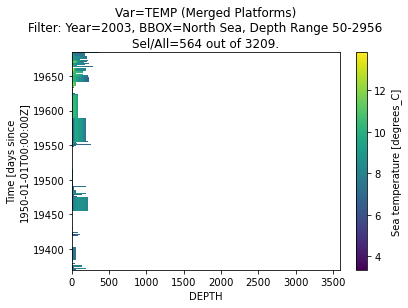

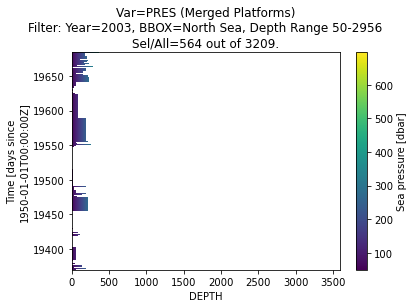

In [53]:
# Combine arrays across platforms, for each variable
merged_arr = {}

for var in vars_sel:
        
    merged_arr[var] = xr.merge([reshaped_dict[pc][var] for pc in reshaped_dict.keys()])  

#     print(var, type(merged_arr[var]), merged_arr[var][var].shape) # Note you need double 'var' because the first is the key of teh dictionary, the second is the name of the var to plot
#     display(merged_arr[var])
    
    title = f'Var={var} (Merged Platforms)\nFilter: Year={year}, {bbox_key}, Depth Range {metadata[pc]["depth_m_v1"]}-{metadata[pc]["depth_m_v2"]}\nSel/All={sel_outof_all}'

    plotVar_MergedPlatforms(merged_arr[var], var, title=title)